In [1]:
import os
import re
import glob
import rasterio
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
from shapely.wkt import loads
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

# Additional data

In [2]:
# Energy consumption 
energy = pd.read_excel(r'D:\Programming\Nighttime\Datasets\ipea_energia.xls')
energy = energy.drop(['Codigo_MWh', 'Estado', '2014', '2015'], axis='columns')
energy.head(5)

Sigla         2016         2017         2018         2019
0    AC   1014245.00   1074277.00    978831.39   1080238.06
1    AL   4880506.00   4959862.00   4708728.22   3875840.70
2    AM   5990565.00   5852472.00   5966425.62   6142168.66
3    AP   1114396.00   1073095.00   1053678.19   1074206.71
4    BA  23945413.24  24331453.93  25092044.05  25908116.93

In [3]:
# Population
pop = pd.read_excel(r'D:\Programming\Nighttime\Datasets\populacao_IBGE.xlsx')
pop.head(5)

UF     state     2016     2017     2018     2019
0  RO  Rondônia  1787279  1805788  1757589  1777225
1  AC      Acre   816687   829619   869265   881935
2  AM  Amazonas  4001667  4063614  4080611  4144597
3  RR   Roraima   514229   522636   576568   605761
4  PA      Pará  8272724  8366628  8513497  8602865

In [4]:
# Agricultural area
agriculture = pd.read_excel(r'D:\Programming\Nighttime\Datasets\area_total_agricola.xlsx')
agriculture.head(5)

estado sigla     2016     2017     2018
0  Rondônia    RO   626280   685672   657384
1      Acre    AC   107294   100543    85185
2  Amazonas    AM   123625   131242   123073
3   Roraima    RR    64121    58398    75257
4      Pará    PA  1567967  1728939  1672372

In [593]:
# Nivel de instrucao (percentual) 
study = pd.read_excel(r'D:\Programming\Nighttime\Datasets\nivel_instrucao_IBGE.xlsx', header=[0,1], index_col=[0])
study.head(4)

4º trimestre 2016                                  4º trimestre 2017  \
Sigla                SI   EFI  EFC  EMI   EMC  ESI   ESC                SI   
AC                 14.0  39.7  8.4  6.7  18.9  4.3   8.1              13.0   
AL                 16.2  44.1  7.4  6.0  17.1  2.8   6.4              15.2   
AM                  9.8  35.7  7.0  7.8  23.1  5.3  11.3               9.4   
AP                 10.2  39.0  7.1  7.5  24.5  3.8   7.9               9.5   

                  ... 4º trimestre 2018            4º trimestre 2019        \
Sigla   EFI  EFC  ...               EMC  ESI   ESC                SI   EFI   
AC     40.4  7.9  ...              20.6  4.4  10.2              12.2  37.6   
AL     44.3  6.8  ...              17.8  2.9   7.9              14.5  43.2   
AM     36.4  7.6  ...              24.3  5.5  10.1               9.9  33.4   
AP     37.7  6.9  ...              26.1  4.6   9.2               8.6  36.5   

                                  
Sigla  EFC  EMI   EMC  ESI   ESC  
AC     7.1  7.3  20.8  3.9  11.1  
AL     6.5  6.6  18.5  2.8   7.9  
AM     7.5  7.7  25.1  5.5  10.9  
AP     6.6  7.6  25.6  4.6  10.5  

[4 rows x 28 columns]

In [594]:
study = study.stack()
study.columns = ['2016', '2017', '2018', '2019']
study.head(4)

2016  2017  2018  2019
   Sigla                        
AC EFC     8.4   7.9   7.7   7.1
   EFI    39.7  40.4  38.6  37.6
   EMC    18.9  18.7  20.6  20.8
   EMI     6.7   6.9   6.8   7.3

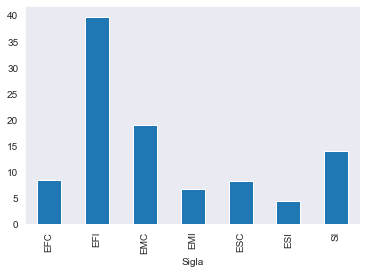

In [716]:
study['2016']['AC'].plot(kind='bar')

#a = study['2018']['SP'].tolist()
#b = study['2018']['AC'].index.tolist()
#plt.bar(x=b, height=a)

In [5]:
# Setting states as index and sorting it
pop = pop.set_index('UF').sort_index()
energy = energy.set_index('Sigla').sort_index()
agriculture = agriculture.set_index('sigla').sort_index()
agriculture = agriculture.set_index('sigla').sort_index()

# Check shape
print(f'Pop shape: {pop.shape}, Energy: {energy.shape}, Agriculture: {agriculture.shape}')

Pop shape: (27, 5), Energy: (27, 4), Agriculture: (27, 4)


In [7]:
# Brazilian geometry shapefile
path_shp = r'D:\Programming\Nighttime\shape\EstadosBR_IBGE_LLWGS84.shp'
shp = gpd.read_file(path_shp)

# Checking shapefile CRS
print('Shapefile CRS ', shp.crs)

Shapefile CRS  {'init': 'epsg:4326'}


In [9]:
# Rewriting shapefile (changing CRS)
shp = shp.to_crs({'init': 'epsg:31982'})
print('Shapefile CRS ', shp.crs)

# Also, let's create a list with states name
states_name = shp['ESTADO'].to_list()

Shapefile CRS  {'init': 'epsg:31982'}


# Nightlight data

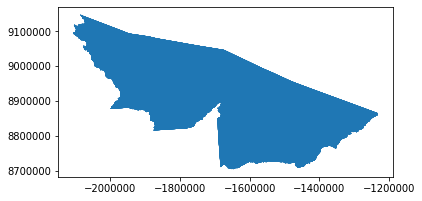

In [10]:
# Catch state.csv files
dfs_list = glob.glob(r'D:\Programming\Nighttime\code\dataframes\\state*.csv')

# Transforming a pandas dataframe to a geodataframe
gdfs = []
for df in dfs_list:
    df = pd.read_csv(df)
    gdf = gpd.GeoDataFrame(df)

    # Since they dont have any Coordinate System we should assign it
    gdf.crs = {'init': 'epsg:31982'}  # original coordinate system from shapefile

    # However, geopandas needs a geometry column to retrieve coordinates
    # Let's do this with shapely wtk.load function
    gdf['geometry'] = gdf['geometry'].apply(loads)

    # Since we using a metric coordinate system, let's calculate state area (km2)
    gdf['area_km'] = gdf['geometry'].area / 10**6
    gdfs.append(gdf)

# Getting a state geometry to plot
gdfs[0].loc[0:11, :].plot()

In [11]:
# Our dataset has all brazilian states
# To facilitate our future work, let's split the datasets
def states_geodataframe(geodataframe, states_list):
    ''' Create multiple state shapefiles from a geodataframe'''
    gdfs = []
    for state in states_list:
        gdf = geodataframe[geodataframe['ESTADO'] == state]
        gdfs.append(gdf)

    return gdfs

gdf2018 = states_geodataframe(gdfs[0], states_name)
gdf2019 = states_geodataframe(gdfs[1], states_name)

print('How many states geodataframes we have? ', len(gdf2018))
print('How many month data have per geodataframe? ', len(gdf2018[0]))

How many states geodataframes we have?  27
How many month data have per geodataframe?  12


# Index section

fazer por trimestre

In [707]:
# Calculando a itensidade luminosa pela area
def light_area(dataframe_list):
    for gdf in dataframe_list:
        gdf['light_area'] = gdf['sum'] / gdf['area_km']

def nldi(dataframe_list, state_list, year):
    for gdf, state in zip(dataframe_list, states_name):
        gdf['NLDI'] = int(pop[pop.index == state][year])/gdf['sum']

def state_mean(dataframe_list, state_list):
    lst = [gdf.mean() for gdf in dataframe_list]
    country = pd.DataFrame(lst, index=state_list)
    return country

# Light/Area
light_area(dataframe_list=gdf2018)
light_area(dataframe_list=gdf2019)

# Light/Pop
nldi(dataframe_list=gdf2018, state_list=states_name, year='2018')
nldi(dataframe_list=gdf2019, state_list=states_name, year='2019')

# Country mean
gdf2018_br = state_mean(gdf2018, states_name)
gdf2019_br = state_mean(gdf2019, states_name)

# Sorting index
gdf2018_br = gdf2018_br.sort_index()
gdf2019_br = gdf2019_br.sort_index()


In [730]:
# Concat info with additional data
def concat_dfs(geodataframe, year):
    join = pd.concat([geodataframe, 
                    pop[year].rename('pop'), 
                    energy[year].rename('energy'), 
                    #agriculture[year].rename('agriculture'), 
                    study.unstack()[year],
                    shp.set_index(shp['ESTADO'])], 
                    axis='columns', 
                    join='inner')

    join = gpd.GeoDataFrame(join,  geometry='geometry')
    join.crs = {'init': 'epsg:31982'} 
    return join

gdf2018_br_info = concat_dfs(gdf2018_br, year='2018')
gdf2019_br_info = concat_dfs(gdf2019_br, year='2019')

Text(0.5, 0.98, '2019')

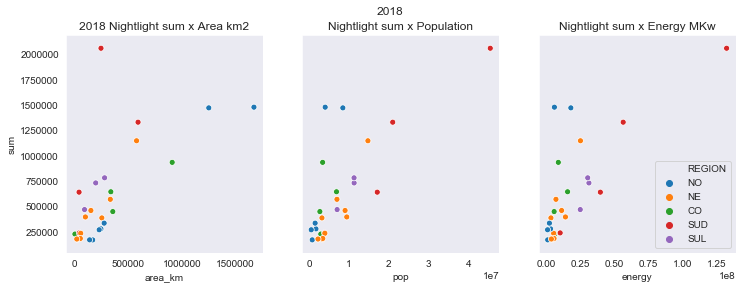

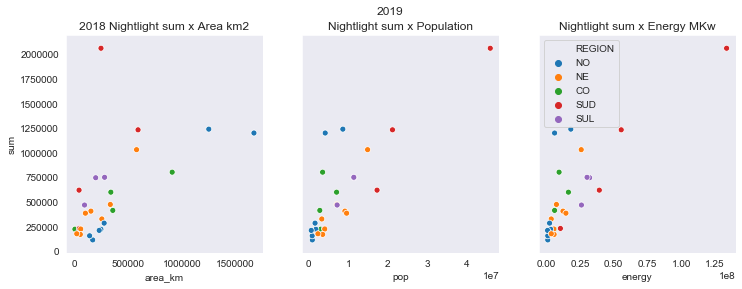

In [738]:
sns.set_style('dark')
#2018
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4), sharey=True)

sns.scatterplot(data=gdf2018_br_info, x='area_km', y='sum', ax=ax[0], hue='REGION', legend=False)
sns.scatterplot(data=gdf2018_br_info, x='pop', y='sum', ax=ax[1], hue='REGION',  legend=False)
sns.scatterplot(data=gdf2018_br_info, x='energy', y='sum', ax=ax[2], hue='REGION')

ax[0].set_title('2018 Nightlight sum x Area km2')
ax[1].set_title('Nightlight sum x Population')
ax[2].set_title('Nightlight sum x Energy MKw')
fig.suptitle('2018')


# 2019
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4), sharey=True)

sns.scatterplot(data=gdf2019_br_info, x='area_km', y='sum', ax=ax[0], hue='REGION', legend=False)
sns.scatterplot(data=gdf2019_br_info, x='pop', y='sum', ax=ax[1], hue='REGION',  legend=False)
sns.scatterplot(data=gdf2019_br_info, x='energy', y='sum', ax=ax[2], hue='REGION')

ax[0].set_title('2018 Nightlight sum x Area km2')
ax[1].set_title('Nightlight sum x Population')
ax[2].set_title('Nightlight sum x Energy MKw')
fig.suptitle('2019')

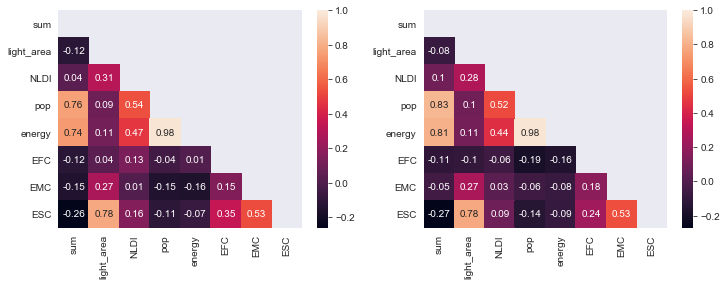

In [748]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

data = gdf2018_br_info[['sum','light_area', 'NLDI','pop', 'energy', 'EFC', 'EMC', 'ESC']]
corr = data.corr().round(2)
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, mask=mask, annot=True, ax=ax[0])

data = gdf2019_br_info[['sum','light_area', 'NLDI','pop', 'energy', 'EFC', 'EMC', 'ESC']]
corr = data.corr().round(2)
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, mask=mask, annot=True, ax=ax[1])

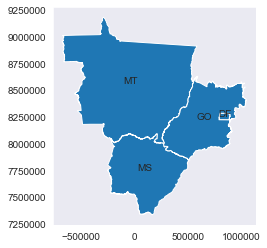

In [46]:
fig, ax = plt.subplots()
shp[shp['REGION'] == 'CO'].plot(ax=ax)
info = shp[shp['REGION'] == 'CO']
info.apply(lambda x: ax.annotate(s=x['ESTADO'], xy=x.geometry.centroid.coords[0], ha='center'),axis=1);

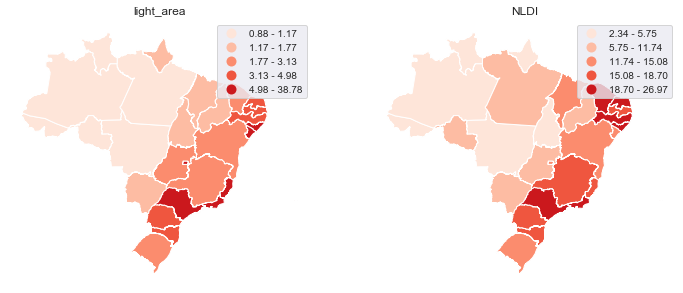

In [749]:
# Creating a colormap from specific colors
colors = ['#fee5d9', '#fcae91', '#fb6a4a', '#cb181d']
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(name="new cmap",
                                                           colors=colors,
                                                           N=5)

fig, ax = plt.subplots(figsize=(12, 8), nrows=1, ncols=2)
ax = ax.flatten()
gdf2018_br_info.plot(column='light_area', cmap=cmap, scheme='quantiles', k=5, legend=True, ax=ax[0])
gdf2018_br_info.plot(column='NLDI', cmap=cmap, scheme='quantiles', k=5, legend=True, ax=ax[1])

ax[0].set_title("light_area", fontsize=12)
ax[1].set_title("NLDI", fontsize=12)
ax[0].set_axis_off()
ax[1].set_axis_off()

#plt.axis('equal');
#join.plot(column='light_area', cmap=cmap, scheme='quantiles', k=5, legend=True)
#join.plot(column='light_pop', cmap=cmap, scheme='quantiles', k=4, legend=True)

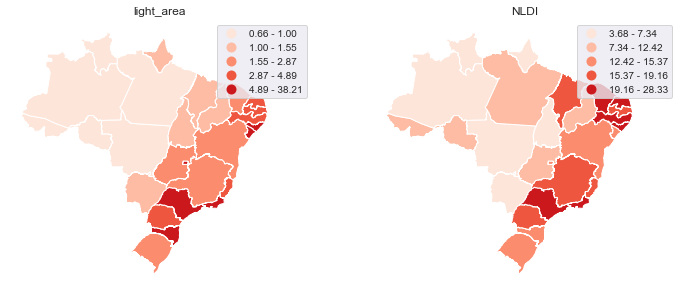

In [750]:
fig, ax = plt.subplots(figsize=(12, 8), nrows=1, ncols=2)
ax = ax.flatten()
gdf2019_br_info.plot(column='light_area', cmap=cmap, scheme='quantiles', k=5, legend=True, ax=ax[0])
gdf2019_br_info.plot(column='NLDI', cmap=cmap, scheme='quantiles', k=5, legend=True, ax=ax[1])

ax[0].set_title("light_area", fontsize=12)
ax[1].set_title("NLDI", fontsize=12)
ax[0].set_axis_off()
ax[1].set_axis_off()